### Intro to LlamaIndex  
Sources: [1](https://lmy.medium.com/comparing-langchain-and-llamaindex-with-4-tasks-2970140edf33), [2](https://docs.llamaindex.ai/en/stable/), [3](https://github.com/run-llama/llama_index), [4](https://nanonets.com/blog/llamaindex/), [5](https://betterprogramming.pub/llamaindex-how-to-use-index-correctly-6f928b8944c6)  

#### Retrieval Augmented Generation (RAG)
LLMs are trained on enormous bodies of data but they aren’t trained on your data. Retrieval-Augmented Generation (RAG) solves this problem by adding your data to the data LLMs already have access to. You will see references to RAG frequently in this documentation.  
In RAG, your data is loaded and prepared for queries or “indexed”. User queries act on the index, which filters your data down to the most relevant context. This context and your query then go to the LLM along with a prompt, and the LLM provides a response.  
Even if what you’re building is a chatbot or an agent, you’ll want to know RAG techniques for getting data into your application.  

#### Stages within RAG
There are five key stages within RAG, which in turn will be a part of any larger application you build. These are:
+ Loading: this refers to getting your data from where it lives – whether it’s text files, PDFs, another website, a database, or an API – into your pipeline. LlamaHub provides hundreds of connectors to choose from.
+ Indexing: this means creating a data structure that allows for querying the data. For LLMs this nearly always means creating vector embeddings, numerical representations of the meaning of your data, as well as numerous other metadata strategies to make it easy to accurately find contextually relevant data.
+ Storing: once your data is indexed you will almost always want to store your index, as well as other metadata, to avoid having to re-index it.
+ Querying: for any given indexing strategy there are many ways you can utilize LLMs and LlamaIndex data structures to query, including sub-queries, multi-step queries and hybrid strategies.
+ Evaluation: a critical step in any pipeline is checking how effective it is relative to other strategies, or when you make changes. Evaluation provides objective measures of how accurate, faithful and fast your responses to queries are.

#### Important concepts within each step
There are also some terms you’ll encounter that refer to steps within each of these stages.  
+ Loading stage
**Nodes** and **Documents**: A Document is a container around any data source - for instance, a PDF, an API output, or retrieve data from a database.  
A Node is the atomic unit of data in LlamaIndex and represents a “chunk” of a source Document. Nodes have metadata that relate them to the document they are in and to other nodes.  
**Connectors**: A data connector (often called a Reader) ingests data from different data sources and data formats into Documents and Nodes.  

+ Indexing Stage  
**Indexes**: Once you’ve ingested your data, LlamaIndex will help you index the data into a structure that’s easy to retrieve. This usually involves generating vector embeddings which are stored in a specialized database called a vector store. Indexes can also store a variety of metadata about your data.  
**Embeddings** LLMs generate numerical representations of data called embeddings. When filtering your data for relevance, LlamaIndex will convert queries into embeddings, and your vector store will find data that is numerically similar to the embedding of your query.  

+ Querying Stage
**Retrievers**: A retriever defines how to efficiently retrieve relevant context from an index when given a query. Your retrieval strategy is key to the relevancy of the data retrieved and the efficiency with which it’s done.  
**Routers**: A router determines which retriever will be used to retrieve relevant context from the knowledge base. More specifically, the RouterRetriever class, is responsible for selecting one or multiple candidate retrievers to execute a query. They use a selector to choose the best option based on each candidate’s metadata and the query.  
Node Postprocessors: A node postprocessor takes in a set of retrieved nodes and applies transformations, filtering, or re-ranking logic to them.  
Response Synthesizers: A response synthesizer generates a response from an LLM, using a user query and a given set of retrieved text chunks.  

#### Putting it all together
There are endless use cases for data-backed LLM applications but they can be roughly grouped into three categories:

+ Query Engines: A query engine is an end-to-end pipeline that allows you to ask questions over your data. It takes in a natural language query, and returns a response, along with reference context retrieved and passed to the LLM.
+ Chat Engines: A chat engine is an end-to-end pipeline for having a conversation with your data (multiple back-and-forth instead of a single question-and-answer).
+ Agents: An agent is an automated decision-maker powered by an LLM that interacts with the world via a set of tools. Agents can take an arbitrary number of steps to complete a given task, dynamically deciding on the best course of action rather than following pre-determined steps. This gives it additional flexibility to tackle more complex tasks.  

### Customizing a RAG Pipeline:

![](https://docs.llamaindex.ai/en/stable/_static/getting_started/basic_rag.png)

#### Installing Packages

In [1]:
!pip install -q openai
!pip install -q llama-index
!pip install -q llama-index-experimental
!pip install -q pypdf
!pip install -q docx2txt

#### Importing Packages

In [2]:
import os
import openai

#os.environ["OPENAI_API_KEY"] = "<the key>"
openai.api_key = os.environ["OPENAI_API_KEY"]

import sys
import shutil
import glob
import logging
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

## Llamaindex readers
from llama_index.core import SimpleDirectoryReader

## LlamaIndex Index Types
from llama_index.core import ListIndex
from llama_index.core import VectorStoreIndex
from llama_index.core import TreeIndex
from llama_index.core import KeywordTableIndex
from llama_index.core import SimpleKeywordTableIndex
from llama_index.core import DocumentSummaryIndex
from llama_index.core import KnowledgeGraphIndex
from llama_index.experimental.query_engine import PandasQueryEngine

## LlamaIndex Context Managers
from llama_index.core import StorageContext
from llama_index.core import load_index_from_storage
from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core.schema import Node

## LlamaIndex Callbacks
from llama_index.core.callbacks import CallbackManager
from llama_index.core.callbacks import LlamaDebugHandler

In [3]:
import logging

#logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
#logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

#### Defining Models

In [55]:
models = """gpt-4, gpt-4-32k, gpt-4-1106-preview, gpt-4-0125-preview, gpt-4-turbo-preview, 
gpt-4-vision-preview, gpt-4-1106-vision-preview, gpt-4-turbo-2024-04-09, gpt-4-turbo, gpt-4-0613, 
gpt-4-32k-0613, gpt-4-0314, gpt-4-32k-0314, gpt-3.5-turbo, gpt-3.5-turbo-16k, gpt-3.5-turbo-0125, 
gpt-3.5-turbo-1106, gpt-3.5-turbo-0613, gpt-3.5-turbo-16k-0613, gpt-3.5-turbo-0301, text-davinci-003, 
text-davinci-002, gpt-3.5-turbo-instruct, text-ada-001, text-babbage-001, text-curie-001, ada, babbage, 
curie, davinci, gpt-35-turbo-16k, gpt-35-turbo, gpt-35-turbo-0125, gpt-35-turbo-1106, gpt-35-turbo-0613, 
gpt-35-turbo-16k-0613""".split()
models = [m.strip(", ") for m in models]
models

['gpt-4',
 'gpt-4-32k',
 'gpt-4-1106-preview',
 'gpt-4-0125-preview',
 'gpt-4-turbo-preview',
 'gpt-4-vision-preview',
 'gpt-4-1106-vision-preview',
 'gpt-4-turbo-2024-04-09',
 'gpt-4-turbo',
 'gpt-4-0613',
 'gpt-4-32k-0613',
 'gpt-4-0314',
 'gpt-4-32k-0314',
 'gpt-3.5-turbo',
 'gpt-3.5-turbo-16k',
 'gpt-3.5-turbo-0125',
 'gpt-3.5-turbo-1106',
 'gpt-3.5-turbo-0613',
 'gpt-3.5-turbo-16k-0613',
 'gpt-3.5-turbo-0301',
 'text-davinci-003',
 'text-davinci-002',
 'gpt-3.5-turbo-instruct',
 'text-ada-001',
 'text-babbage-001',
 'text-curie-001',
 'ada',
 'babbage',
 'curie',
 'davinci',
 'gpt-35-turbo-16k',
 'gpt-35-turbo',
 'gpt-35-turbo-0125',
 'gpt-35-turbo-1106',
 'gpt-35-turbo-0613',
 'gpt-35-turbo-16k-0613']

In [5]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

model="gpt-3.5-turbo"
#model="gpt-4"
#model="gpt-4-turbo"

Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")
Settings.llm = OpenAI(temperature=0, 
                      model=model, 
                      #max_tokens=512
                      PRESENCE_PENALTY=-2,
                      TOP_P=1,
                     )

#### Defining and Examining Folders

In [6]:
DOCS_DIR = "../Data/"
PERSIST_DIR = "../Index/"

print(f"Current dir: {os.getcwd()}")

if not os.path.exists(DOCS_DIR):
  os.mkdir(DOCS_DIR)
docs = os.listdir(DOCS_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {DOCS_DIR}")
for doc in docs:
    print(doc)

Current dir: /home/renato/Documents/Repos/GenAI4Humanists/Notebooks
Files in ../Data/
1.pdf
WarrenCommissionReport.txt
axis_report.pdf
california_housing_train.csv
hdfc_report.pdf
hr.sqlite
icici_report.pdf
kafka_metamorphosis.txt
knowledge_card.pdf
loftq.pdf
longlora.pdf
lyft_2021.pdf
metagpt.pdf
metra.pdf
paul_graham_essay.txt
selfrag.pdf
swebench.pdf
uber_2021.pdf
values.pdf
vr_mcl.pdf
zipformer.pdf


### Creating the Index    

LlamaIndex is known for offering [different types of indexes](https://docs.llamaindex.ai/en/stable/module_guides/indexing/indexing.html); each one is more suited to a different purpose.
***
There are important aspects to regard, namely: indexation cost, and indexation time (speed).  
+ Indexing Cost: The expense of indexing is a crucial factor to consider. This is particularly significant when dealing with massive datasets.  
+ Indexing Speed: The second important issue is the time of document indexing, i.e. preparing the entire solution for operation. Indexation time varies but it is a one-off and also depends on the OpenAI server.  
Usually, the pdf with 40 pages will take approximately 5 seconds. Imagine a huge dataset with more than 100k pages, it could take to several days. We can leverage the async method to reduce the indexing time.  

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*cyRHH_0z39JmFGeLYBWFEA.png)

Sources: [1](https://betterprogramming.pub/llamaindex-how-to-use-index-correctly-6f928b8944c6), [2](https://docs.llamaindex.ai/en/stable/module_guides/indexing/indexing.html), [3](https://mikulskibartosz.name/llama-index-which-index-should-you-use)

#### [Storage Context](https://docs.llamaindex.ai/en/stable/api_reference/storage.html)  
LlamaIndex offers core abstractions around storage of Nodes, indices, and vectors. A key abstraction is the StorageContext - this contains the underlying BaseDocumentStore (for nodes), BaseIndexStore (for indices), and VectorStore (for vectors).
StorageContext defines the storage backend for where the documents, embeddings, and indexes are stored.   
```
storage_context = StorageContext.from_defaults(persist_dir="<path/to/index>")
```
You can learn more about [storage](https://docs.llamaindex.ai/en/stable/module_guides/storing/storing.html) and how to [customize](https://docs.llamaindex.ai/en/stable/module_guides/storing/customization.html) it.  

#### (Optional) Creating Folder / Deleting existing Indexes  

In [7]:
if not os.path.exists(PERSIST_DIR):
    print(f"Creating Directory {PERSIST_DIR}")
    os.mkdir(PERSIST_DIR)
else:
    print(f"Re-Creating Directory {PERSIST_DIR}")
    shutil.rmtree(PERSIST_DIR)
    os.mkdir(PERSIST_DIR)

Re-Creating Directory ../Index/


### We are going to use a big document:  
["Metamorphosis by Franz Kafka"](https://www.gutenberg.org/ebooks/5200)  

"kafka_metamorphosis.txt"

#### Generic Function to create indexes

In [8]:
from llama_index.core.node_parser import SentenceSplitter
splitter = SentenceSplitter(chunk_size=2048)

response_synthesizer = get_response_synthesizer(
    response_mode="tree_summarize", use_async=True
)


In [9]:
def create_retrieve_index(index_path, docs_path, index_type):
    if not os.path.exists(index_path):
        print(f"Creating Directory {index_path}")
        os.mkdir(index_path)
    if os.listdir(index_path) == []:
        print("Loading Documents...")
        documents = SimpleDirectoryReader(input_files=[f"{docs_path}kafka_metamorphosis.txt"]).load_data()
        print("Creating Index...")
        index = index_type.from_documents(documents,
                                          transformations=[splitter],
                                          #response_synthesizer=response_synthesizer,
                                          show_progress=True,
                                          )
        print("Persisting Index...")
        index.storage_context.persist(persist_dir=index_path)
        print("Done!")
    else:
        print("Reading from Index...")
        index = load_index_from_storage(storage_context=StorageContext.from_defaults(persist_dir=index_path))
        print("Done!")
    return index

#### Some remarks:
+ We will load documens from a directory, but you can check all integrations (readers) [here](https://llamahub.ai/?tab=loaders)  
+ We could also transform documents in nodes and create the index directly from [nodes](https://docs.llamaindex.ai/en/stable/api_reference/service_context/node_parser.html)  


#### A) Creating (or loading) List Index  
~ 1 min   

The list index is a simple data structure where nodes are stored in a sequence.  
The document texts are chunked up, converted to nodes, and stored in a list during index construction.
The GPTListIndex index is perfect when you don’t have many documents. Instead of trying to find the relevant data, the index concatenates all chunks and sends them all to the LLM. If the resulting text is too long, the index splits the text and asks LLM to refine the answer.  
GPTListIndex may be a good choice when we have a few questions to answer using a handful of documents. It may give us the best answer because AI will get all the available data, but it is also quite expensive. We pay per token, so sending all the documents to the LLM may not be the best idea.  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*rBBHy019pbV9kyxh.png)
![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*8ANcn6OBBVzIHAd0.png)
![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*NQAUXYHPq0wh8zhw.png)

In [10]:
LISTINDEXDIR = PERSIST_DIR + 'ListIndex'
listindex = create_retrieve_index(LISTINDEXDIR, DOCS_DIR, ListIndex)

Creating Directory ../Index/ListIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Persisting Index...
Done!


#### B) Creating (or loading) Vector Store Index  
~ 3 min (Local) / 7 min (OpenAI)  

It is most common and simple to use, allows answering a query over a large corpus of data  
By default, LlamaIndex uses a simple in-memory vector store, but you can use [another solution](https://docs.llamaindex.ai/en/stable/module_guides/storing/vector_stores.html)   
VectorStoreIndex creates numerical vectors from the text using word embeddings and retrieves relevant documents based on the similarity of the vectors.  
When we index the documents, the library chunks them into a number of nodes and calls the embeddings endpoint of OpenAI API by default.  Unlike list index, vector-store based indices generate embeddings during index construction  
The number of API calls during indexing depends on the amount of data. GPTVectorStoreIndex can use the embeddings API or a Local Model.
When we ask a question, it will create a vector from the question, retrieve relevant data, and pass the text to the LLM. The LLM will generate the answer using our question and the retrieved documents. Using GPTVectorStoreIndex, we can implement the most popular method of passing private data to LLMs which is to create vectors using word embeddings and find relevant documents based on the similarity between the documents and the question.  It has an obvious advantage. It is cheap to index and retrieve the data. We can also reuse the index to answer multiple questions without sending the documents to LLM many times. The disadvantage is that the quality of the answers depends on the quality of the embeddings. If the embeddings are not good enough, the LLM will not be able to generate a good responses.  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*IbHJovGnj38dDHsB.png)
![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*-9QtrMEBYrAFWDMH.png)

In [11]:
VECTORINDEXDIR = PERSIST_DIR + 'VectorStoreIndex'
vectorstoreindex = create_retrieve_index(VECTORINDEXDIR, DOCS_DIR, VectorStoreIndex)

Creating Directory ../Index/VectorStoreIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

Persisting Index...
Done!


#### C) Creating (or loading) Tree Index  
~ 3 min  
It is useful for summarizing a collection of documents  
The tree index is a tree-structured index, where each node is a summary of the children's nodes.  
During index construction, the tree is constructed in a bottoms-up fashion until we end up with a set of root nodes.  
The tree index builds a hierarchical tree from a set of Nodes (which become leaf nodes in this tree).  
Unlike vector index, LlamaIndex won’t call LLM to generate embedding but will generate it during query time.   
Embeddings are lazily generated and then cached (if retriever_mode="embedding" is specified during query(...)), and not during index construction.  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*906uyjc0HBDfiyzw.png)  
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*CpUvD5VejES-JdRq.png)

In [12]:
TREEINDEXDIR = PERSIST_DIR + 'TreeIndex'
treeindex = create_retrieve_index(TREEINDEXDIR, DOCS_DIR, TreeIndex)

Creating Directory ../Index/TreeIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating summaries:   0%|          | 0/2 [00:00<?, ?it/s]

Persisting Index...
Done!


#### D) Creating (or loading) Keyword Table Indexes (embeddings)  
~ 14 min (Local) / 12 min (OpenAI)  

It is useful for routing queries to the disparate data source  
The keyword table index extracts keywords from each Node and builds a mapping from each keyword to the corresponding Nodes of that keyword.  
During query time, we extract relevant keywords from the query and match those with pre-extracted Node keywords to fetch the corresponding Nodes. The extracted Nodes are passed to the Response Synthesis module. GPTKeywordTableIndex use LLM to extract keywords from each document, meaning it do require LLM calls during build time. However, if you use GPTSimpleKeywordTableIndex which uses a regex keyword extractor to extract keywords from each document, it won’t call LLM during build time  
The bulk of the work happens at the indexing time. Every node is sent to the LLM to generate keywords, and sending every document to an LLM increases the cost of indexing. Not only because we pay for the tokens but also because calls to the Completion API of OpenAI take longer than their Embeddings API.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*DUR4yHaMam-vln3t.png)
![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*ERSNFpKoKfbIICkz.png)

In [13]:
KEYWORDINDEXDIR = PERSIST_DIR + 'KeywordIndex'
keywordindex = create_retrieve_index(KEYWORDINDEXDIR, DOCS_DIR, KeywordTableIndex)

Creating Directory ../Index/KeywordIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting keywords from nodes:   0%|          | 0/16 [00:00<?, ?it/s]

Persisting Index...
Done!


In [44]:
print(keywordindex.index_struct.to_dict().keys())
keywordindex.index_struct.to_dict()

dict_keys(['index_id', 'summary', 'table'])


{'index_id': 'b917b90b-6d1a-431c-9a63-412975a72b60',
 'summary': None,
 'table': {'family': ['77df84f0-f185-40e9-8ff2-12fa5858bf07',
   'a11f9de8-427a-4fad-8ec8-f0021a2ef8cf',
   '8a78964a-b336-47bf-8625-50d7fce96712',
   '25187b9b-1a6c-45ae-9e6e-5499c5262b10',
   '2fd85331-2e58-4f37-8ef9-f0425ed5e490',
   '3cf53b37-a98f-49f7-807a-265c532f5f78',
   '9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'gregor samsa': ['9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'franz': ['9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'metamorphosis': ['9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'gregor': ['0ace2393-af69-46ba-8dcd-01072cad58c6',
   'a11f9de8-427a-4fad-8ec8-f0021a2ef8cf',
   '585ac98b-e033-46e7-821c-7f2649d43875',
   '9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'david': ['9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'gutenberg': ['9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'project gutenberg': ['9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'wyllie': ['9cb1dd3f-2dbe-4927-a2a3-ffda0207fa4b'],
  'salesman': ['9cb1dd

#### D2) Creating (or loading) Simple Keyword Table Indexes (regex)  
~ 1 min  

In [15]:
SIMPLEKEYWORDINDEXDIR = PERSIST_DIR + 'SimpleKeywordIndex'
simplekeywordindex = create_retrieve_index(SIMPLEKEYWORDINDEXDIR, DOCS_DIR, SimpleKeywordTableIndex)

Creating Directory ../Index/SimpleKeywordIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting keywords from nodes:   0%|          | 0/16 [00:00<?, ?it/s]

Persisting Index...
Done!


In [45]:
print(simplekeywordindex.index_struct.to_dict().keys())
simplekeywordindex.index_struct.to_dict()

dict_keys(['index_id', 'summary', 'table'])


{'index_id': 'ce7827b6-9fea-45fa-8309-d86aaf05758a',
 'summary': None,
 'table': {'feel': ['e8ba8bd1-6ca4-4900-b900-9441046e0a44'],
  'would': ['e8ba8bd1-6ca4-4900-b900-9441046e0a44',
   'ce10be21-ed7f-43a8-bc70-3f73f6ce24eb',
   'bce51fdc-ad69-4135-8cbe-60d182377bb8',
   'c1eab9e9-5e1a-40c7-9bad-0277d4411c56',
   '2669f81d-1f39-4620-9c5a-78f152007a33',
   '4a28ef2e-a91e-433e-9c5d-3aaedf7adf61',
   'd7e10659-f9d7-498b-9931-070d306f72bd',
   '5c81c40c-7f12-4276-a256-d6846f013ff4',
   'a54b3e84-d9cf-4e7f-92db-5ebf9d13cf7a',
   '88a1e24e-e0d2-495d-bbff-61cc9e7595d6',
   '684ab853-28c1-4eb3-a9c4-d37f03c060c2',
   '28a6eff1-7ede-4600-ac75-ac6e00cf83ca'],
  'gregor': ['e8ba8bd1-6ca4-4900-b900-9441046e0a44',
   'ce10be21-ed7f-43a8-bc70-3f73f6ce24eb',
   '00e4a371-71ad-4656-b466-8d0d4addde1f',
   'bce51fdc-ad69-4135-8cbe-60d182377bb8',
   'c1eab9e9-5e1a-40c7-9bad-0277d4411c56',
   '2669f81d-1f39-4620-9c5a-78f152007a33',
   '4a28ef2e-a91e-433e-9c5d-3aaedf7adf61',
   'd7e10659-f9d7-498b-9931-070

#### E) Creating (or loading) Document Summary Index  
~ 19 min (Local) / 17 min (OpenAI)  

This index can extract and index an unstructured text summary for each document, which enhances retrieval performance beyond existing approaches. It contains more information than a single text chunk and carries more semantic meaning than keyword tags. It also allows for flexible retrieval, including both LLM and embedding-based approaches. During build-time, this index ingests document and use LLM to extract a summary from each document. During query time, it retrieves relevant documents to query based on summaries using the following approaches:  
+ LLM-based Retrieval: get collections of document summaries and request LLM to identify the relevant documents + relevance score  
+ Embedding-based Retrieval: utilize summary embedding similarity to retrieve relevant documents, and impose a top-k limit to the number of retrieved results.  


![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*Sr1_53f_HAXwbsQ5.png)

In [20]:
DSUMMARYINDEXDIR = PERSIST_DIR + 'DSummaryIndex'
dsummaryindex = create_retrieve_index(DSUMMARYINDEXDIR, DOCS_DIR, DocumentSummaryIndex)

Creating Directory ../Index/DSummaryIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Summarizing documents:   0%|          | 0/1 [00:00<?, ?it/s]

current doc id: 5629a81c-8b8f-4d4a-a760-cd560998a6f5


Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Persisting Index...
Done!


#### F) Creating (or loading) Knowledge Graph Index  
~ 21 min  (Local) / 17 min (OpenAI)

It builds a knowledge graph with keywords and relations between nodes, consuming a lot of resources.  
The default behavior of GPTKnowledgeGraphIndex is based on keywords, but we can use embeddings by specifying the retriever_mode parameter (KGRetrieverMode.EMBEDDING)  
It builds the index by extracting knowledge triples in the form (subject, predicate, object) over a set of docs. During the query time, it can either query using just the knowledge graph as context or leverage the underlying text from each entity as context. By leveraging the underlying text, we can ask more complicated queries with respect to the contents of the document.  
With LlamaIndex, you have the ability to create composite indices by building indices on top of existing ones. This feature empowers you to efficiently index your complete document hierarchy and provide tailored knowledge to GPT.
By leveraging composability, you can define indices at multiple levels, such as lower-level indices for individual documents and higher-level indices for groups of documents.  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*rEg1wqA7V7HXUWy4LP6zXQ.png)

In [18]:
KGGRAPHINDEXDIR = PERSIST_DIR + 'KGraphIndex'
kgraphindex = create_retrieve_index(KGGRAPHINDEXDIR, DOCS_DIR, KnowledgeGraphIndex)

Creating Directory ../Index/KGraphIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/16 [00:00<?, ?it/s]

Persisting Index...
Done!


## Retrieving your data  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*XqAckrehpK4MYt35.jpg)

LlamaIndex provides a high-level API that facilitates straightforward querying, ideal for common use cases.
```
query_engine = index.as_query_engine()
response = query_engine.query("your_query")
print(response)
```

```as_query_engine``` builds a default retriever and query engine on top of the index.  
You can check check out the query engine, chat engine and agents sections [here](https://docs.llamaindex.ai/en/stable/module_guides/querying/querying.html)

Depending on how you created your index, the first step is to compare your query with the chunks of text stored in the index:

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Retrieval-Step.png)

We can try different [response modes](https://docs.llamaindex.ai/en/stable/module_guides/deploying/query_engine/response_modes.html)
Here are some differences between them ([source](https://www.bluelabellabs.com/blog/llamaindex-response-modes-explained/))

+ refine: create and refine an answer by sequentially going through each retrieved text chunk. This makes a separate LLM call per Node/retrieved chunk.
Details: the first chunk is used in a query using the text_qa_template prompt. Then the answer and the next chunk (as well as the original question) are used in another query with the refine_template prompt. And so on until all chunks have been parsed. If a chunk is too large to fit within the window (considering the prompt size), it is split using a TokenTextSplitter (allowing some text overlap between chunks) and the (new) additional chunks are considered as chunks of the original chunks collection (and thus queried with the refine_template as well). Good for more detailed answers. The refine mode is very similar to the compact Response Mode, except that instead of attempting to concatenate as many chunks as it can to maximize the use of the LLM token limit, LlamaIndex only include 1 chunk of retrieved data for each LLM call. Starting with the text_qa_template, LlamaIndex passes in Chunk 1 to the LLM. After that, LlamaIndex then progresses sequentially through each of the remaining chunks one at a time; with each subsequent LLM call using the refine_template to build upon the answer returned from the answer returned from the previous chunk.

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Refine-v2-1.png)  

+ compact (default): similar to refine but compact (concatenate) the chunks beforehand, resulting in less LLM calls.
Details: stuff as many text (concatenated/packed from the retrieved chunks) that can fit within the context window (considering the maximum prompt size between text_qa_template and refine_template). If the text is too long to fit in one prompt, it is split in as many parts as needed (using a TokenTextSplitter and thus allowing some overlap between text chunks). Each text part is considered a “chunk” and is sent to the refine synthesizer. In short, it is like refine, but with less LLM calls. The Response Mode called compact is the default mode used by LlamaIndex if none is specified. The way the compact mode works is that for each chunk that is returned from the retrieval step, LlamaIndex concatenates as many of those chunks together into the largest possible string that fits into a single prompt to

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Compact.png)

+ tree_summarize: Query the LLM using the summary_template prompt as many times as needed so that all concatenated chunks have been queried, resulting in as many answers that are themselves recursively used as chunks in a tree_summarize LLM call and so on, until there’s only one chunk left, and thus only one final answer.
Details: concatenate the chunks as much as possible to fit within the context window using the summary_template prompt, and split them if needed (again with a TokenTextSplitter and some text overlap). Then, query each resulting chunk/split against summary_template (there is no refine query !) and get as many answers. If there is only one answer (because there was only one chunk), then it’s the final answer.
If there are more than one answer, these themselves are considered as chunks and sent recursively to the tree_summarize process (concatenated/splitted-to-fit/queried). Good for summarization purposes. by far most effective, Response Mode is tree_summarize. The astute reader might surmise from the use of the word ‘tree’ that there is a recursive property to this response mode, and they would be correct. The tree_summarize mode in its base case makes a series of LLM calls that concatenate chunks of retrieved data so that it maximizes the input token limit for the LLM. It then takes the outputs of each of these base case responses, and then passes them together to the LLM and instructs it to derive an answer using those initial answers as context.

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Tree-Summarize.png)

+ simple_summarize: Truncates all text chunks to fit into a single LLM prompt. Good for quick summarization purposes, but may lose detail due to truncation. This perhaps the most basic and straightforward of the response modes. In this mode, LlamaIndex truncates all text chunks so that all chunks can be concatenated and passed into the LLM in a single call. No matter how many chunks are retrieved, there will only ever be a single call made to the LLM.

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Simple-Summarize.png)

+ accumulate: Given a set of text chunks and the query, apply the query to each text chunk while accumulating the responses into an array. Returns a concatenated string of all responses. Good for when you need to run the same query separately against each text chunk. LlamaIndex makes 1 call per retrieved chunk and then returns every ‘non-null’ answer together as an array of answers. For each of the calls that LlamaIndex makes in accumulate mode, it uses a similar template to tree_summarize:

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Accumulate.png)

+ compact_accumulate: The same as accumulate, but will “compact” each LLM prompt similar to compact, and run the same query against each text chunk. 

+ no_text: Only runs the retriever to fetch the nodes that would have been sent to the LLM, without actually sending them. Then can be inspected by checking response.source_nodes.

---

#### A) Retrieving from [List Index](https://docs.llamaindex.ai/en/stable/api_reference/query/retrievers/list.html)  
~ 5 min

LlamaIndex provides embedding support to list indices.  
In addition to each node storing text, each node can optionally store an embedding. During query time, we can use embeddings to do max-similarity retrieval of nodes before calling the LLM to synthesize an answer.  
Since similarity lookup using embeddings (e.g. using cosine similarity) does not require an LLM call, embeddings serve as a cheaper lookup mechanism instead of using LLMs to traverse nodes.

In [22]:
query_engine = listindex.as_query_engine(similarity_top_k=3,
                                         #keyword_filter=["Kafka"],
                                         response_mode="compact",
                                         verbose=True,
                                         )
response = query_engine.query("What is the book about?")
print(response)

The book delves into the tale of Gregor Samsa, who undergoes a startling transformation into a large insect-like creature. It delves into his struggles in adjusting to this new state and the impact it has on his family, particularly his sister who takes care of him. Central themes include isolation, alienation, and family relationships as Gregor and his family grapple with the challenges stemming from his metamorphosis.


In [24]:
response = query_engine.query("How the insect looks like?")
print(response)

The insect in the story "Metamorphosis" by Franz Kafka is described as having a dreadful vermin-like appearance, with a brown belly, numerous thin legs in contrast to its body size, and white spots on its belly.


#### B) Retrieving from [Vector Store Index](https://docs.llamaindex.ai/en/stable/api_reference/query/retrievers/vector_store.html)  
~ 2 Seconds  

In [27]:
query_engine = vectorstoreindex.as_query_engine(retriever_mode="embedding",
                                                response_mode="compact",
                                                verbose=True)
response = query_engine.query("What is the book about?")
print(response)

The book is about a man named Gregor Samsa who wakes up one morning to find himself transformed into a horrible vermin. The story follows his struggles to come to terms with his new form and how his transformation affects his relationships with his family members.


In [28]:
response = query_engine.query("How the insect looks like?")
print(response)

The insect's appearance is not explicitly described in the provided context information.


#### C) Retrieving from [Tree Index](https://docs.llamaindex.ai/en/stable/api_reference/query/retrievers/tree.html)
~ 2.5 min  

In [29]:

query_engine = treeindex.as_query_engine(response_mode="tree_summarize",
                                         retriever_mode="all_leaf",
                                         child_branch_factor=1,
                                         verbose=True
                                        )
response = query_engine.query("What is the book about?")
print(response)

The book is about a man named Gregor who experiences a sudden and inexplicable transformation into a vermin-like creature. The narrative explores Gregor's challenges in adapting to his new form and the effects it has on his family, especially his sister who becomes his primary caregiver. Themes of isolation, family dynamics, and the struggle to accept unexpected circumstances are central to the story.


In [30]:
response = query_engine.query("How the insect looks like?")
print(response)

The insect in the story is described as a horrible vermin or a giant insect.


#### D) Retrieving from [SimpleKeywordTableIndex and KeywordTableIndex](https://docs.llamaindex.ai/en/stable/api_reference/query/retrievers/table.html)  
~ 3 seconds  

In [49]:
query_engine = simplekeywordindex.as_query_engine(verbose=True,
                                                  response_mode="compact",
                                                  )
response = query_engine.query("What is the book about?")
print(response)

Empty Response


In [50]:
response = query_engine.query("Who is Gregor?")
print(response)

Gregor is a character in the story who has undergone a transformation into a horrible vermin. He is a member of a family who, despite his new form, is still considered a family member and is dealt with in various ways by his family members.


In [51]:
query_engine = keywordindex.as_query_engine(verbose=True,
                                            response_mode="compact",
                                        )
response = query_engine.query("What is the book about?")
print(response)

Empty Response


In [52]:
response = query_engine.query("Who is Gregor?")
print(response)

Gregor is the main character in the story "Metamorphosis" by Franz Kafka.


#### E) Retrieving from [Document Summary Index](https://docs.llamaindex.ai/en/latest/examples/index_structs/doc_summary/DocSummary.htmll)  
~ 1 second  

In [37]:
query_engine = dsummaryindex.as_query_engine(verbose=True,
                                           response_mode="compact",
                                           )
response = query_engine.query("What is the book about?")
print(response)

#response = response_synthesizer.synthesize("query text", nodes=[Node(text="text"), ...])

The book follows the story of Gregor Samsa, who wakes up one morning to discover he has transformed into a large insect-like creature. It delves into his challenges in adapting to this new form and how it affects his relationships with his family.


In [38]:
list(dsummaryindex.ref_doc_info.keys())[0:10]

['5629a81c-8b8f-4d4a-a760-cd560998a6f5']

In [39]:
dsummaryindex.get_document_summary(doc_id=list(dsummaryindex.ref_doc_info.keys())[0])

'The provided text is an excerpt from the novella "Metamorphosis" by Franz Kafka, which tells the story of Gregor Samsa waking up one morning to find himself transformed into a giant insect. It explores themes of isolation, alienation, family dynamics, and the impact of Gregor\'s transformation on his relationships with his family members. The text delves into Gregor\'s struggles to adapt to his new form and the emotional turmoil he experiences, as well as his family\'s reactions to his metamorphosis.\n\nSome questions that this text can answer include:\n- How does Gregor\'s family react to his transformation?\n- What challenges does Gregor face in his new form?\n- How does Gregor\'s transformation affect his family\'s dynamics?\n- What emotions and thoughts does Gregor experience throughout the story?\n- How does the outside world perceive Gregor\'s transformation?'

#### F) Retrieving from [Knowledge Graph Index](https://docs.llamaindex.ai/en/stable/examples/index_structs/knowledge_graph/KnowledgeGraphDemo.html)  
~ 1 second

In [53]:
query_engine = kgraphindex.as_query_engine(verbose=True,
                                           response_mode="compact",
                                           )
response = query_engine.query("What is the book about?")
print(response)

Extracted keywords: ['book']
The book's content is not related to any relationships.


In [54]:
response = query_engine.query("Who is Gregor?")
print(response)

Extracted keywords: ['Gregor']
KG context:
The following are knowledge sequence in max depth 2 in the form of directed graph like:
`subject -[predicate]->, object, <-[predicate_next_hop]-, object_next_hop ...`
['Gregor', 'Answered to', 'Father']
['Gregor', 'Whispered', 'Sister']
['Gregor', 'Congratulated himself for', 'Habit']
['Gregor', 'Wanted to do', 'Get up']
['Gregor', 'Managed', 'Turning his head']
['Gregor', 'Tried to get', 'Top part of body']
['Gregor', 'Set himself to', 'Task']
['Gregor', 'Tried to imagine', 'Something']
['Gregor', 'Tried to imagine', 'Happen to chief clerk']
['Gregor', 'Had', 'Small symptom']
['Gregor', 'Tried to imagine', 'Something']
['Gregor', 'Lay on', 'Carpet']
['Gregor', 'Turned', 'Head']
['Gregor', 'Whispered to', 'Sister']
['Gregor', 'Said', 'Himself']
['Gregor', 'Raised', 'Voice']
['Gregor', 'Called', 'Himself']
['Gregor', 'Made', 'Way']
['Gregor', 'Tried to climb', 'Chest of drawers']
['Gregor', 'Kept calm', 'Only one']
['Gregor', 'Get dressed', 'St

#### GPTKnowledgeGraphIndex comes with an additional benefit.  
#### We can retrieve the knowledge graph, and we can even visualize it with the networkx library.

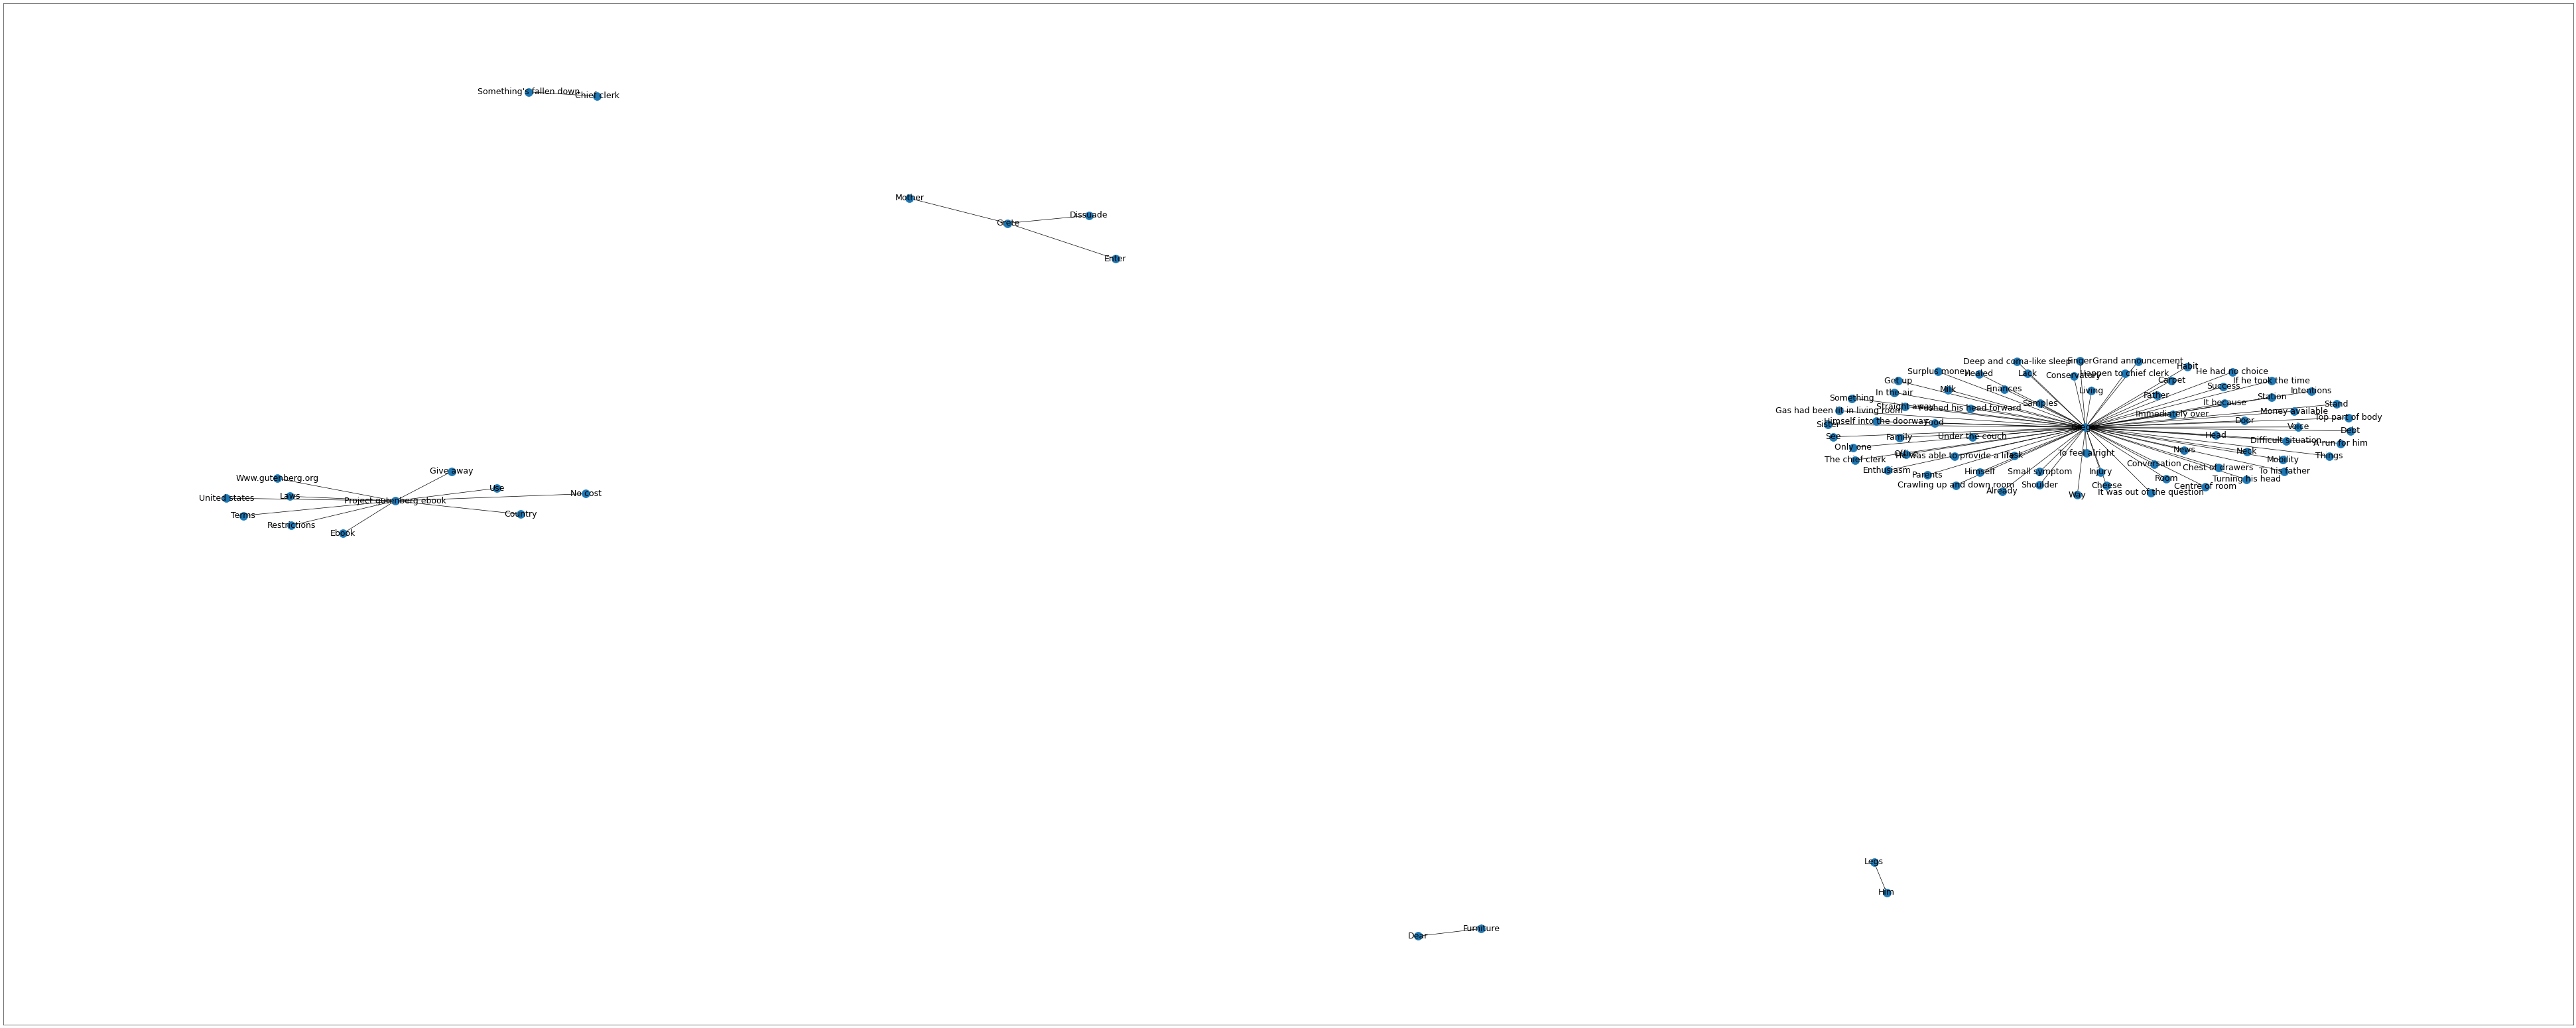

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(100, 40), dpi=50)
nx.draw_networkx(kgraphindex.get_networkx_graph(), font_size=18)

#### F) Pandas Index

Good to query Dataframes  
Error: https://stackoverflow.com/questions/77445728/pandasqueryengine-from-llama-index-is-unable-to-execute-code-with-the-following

In [42]:
df = pd.read_csv("../Data/california_housing_train.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [43]:
query_engine = PandasQueryEngine(df=df, verbose=True)
response = query_engine.query("What is maximum total bedrooms?",)
response

> Pandas Instructions:
```
df['total_bedrooms'].max()
```
> Pandas Output: 6445.0


Response(response='6445.0', source_nodes=[], metadata={'pandas_instruction_str': "df['total_bedrooms'].max()", 'raw_pandas_output': '6445.0'})